# Train Linear Expression Decoder

Trains a linear probe decoder on frozen BioJEPA latent representations to predict expression deltas.

The trained decoder is used by evaluation notebooks (eval_1, eval_2, etc.).

## Setup

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn.functional as F
import numpy as np
from pathlib import Path
import random
import matplotlib.pyplot as plt

import biojepa_ac_v0_4 as model
from bio_dataloader import TrainingLoader
from linear_expression_decoder import BenchmarkDecoder, BenchmarkDecoderConfig

In [2]:
random.seed(1337)

def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    print(f'using {device}')
    return device

DEVICE = get_device()

using cpu


In [3]:
batch_size = 32

n_genes = 5000
n_layers = 2
n_heads = 2
n_embd = 8
pert_latent_dim = 320
pert_mode_dim = 64

In [4]:
data_dir = Path('/Users/djemec/data/jepa/v0_4')
train_dir = data_dir / 'training'
checkpoint_dir = data_dir / 'checkpoints'
pert_dir = data_dir / 'pert_embd'

In [5]:
input_bank = torch.from_numpy(np.load(pert_dir / 'input_embeddings_dna.npy')).float().to(DEVICE)
print(f'Input Bank (DNA): {input_bank.shape}')

Input Bank (DNA): torch.Size([1250, 1536])


## Load BioJEPA Model

In [6]:
torch.set_float32_matmul_precision('high')
config = model.BioJepaConfig(
    num_genes=n_genes,
    n_layer=n_layers,
    heads=n_heads,
    embed_dim=n_embd,
    n_pre_layer=n_layers,
    pert_latent_dim=pert_latent_dim,
    pert_mode_dim=pert_mode_dim
)
biojepa = model.BioJepa(config).to(DEVICE)

In [7]:
checkpoint_path = checkpoint_dir / 'bio_jepa_ckpt_31769_final.pt'
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
keys = biojepa.load_state_dict(checkpoint['model'])
print(keys)

<All keys matched successfully>


In [8]:
biojepa.freeze_encoders()
biojepa.eval()
for param in biojepa.parameters():
    param.requires_grad = False

## Data Loaders

In [9]:
train_loader = TrainingLoader(batch_size=batch_size, split='train', data_dir=train_dir, device=DEVICE)
val_loader = TrainingLoader(batch_size=batch_size, split='val', data_dir=train_dir, device=DEVICE)

found 11 shards for split train
loading /Users/djemec/data/jepa/v0_4/training/train/shard_k562e_train_0000.npz
found 2 shards for split val
loading /Users/djemec/data/jepa/v0_4/training/val/shard_k562e_val_0001.npz


## Initialize Decoder

In [10]:
decoder_config = BenchmarkDecoderConfig(embed_dim=n_embd)
decoder = BenchmarkDecoder(decoder_config).to(DEVICE)
print(f'Decoder parameters: {sum(p.numel() for p in decoder.parameters()):,}')

Decoder parameters: 9


## Training Config

In [11]:
lr_decoder = 1e-3
epochs = 5

train_total_examples = 101682
steps_per_epoch = train_total_examples // batch_size
max_steps = epochs * steps_per_epoch

print(f'Steps per epoch: {steps_per_epoch}')
print(f'Total steps: {max_steps}')

Steps per epoch: 3177
Total steps: 15885


In [12]:
optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr_decoder)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr_decoder, total_steps=max_steps, pct_start=0.05
)

## Training Loop

In [13]:
lossi = []
val_lossi = []
total_epoch_loss = 0

decoder.train()

for step in range(max_steps):
    last_step = (step == max_steps - 1)

    if step % 100 == 0 or last_step:
        biojepa.eval()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 10
            for i in range(val_loss_steps):
                xc, xct, xt, xtt, p_idx, p_mod, p_mode = val_loader.next_batch()
                p_feats = input_bank[p_idx]
                B, N = xc.shape

                action_latents = biojepa.composer(p_feats, p_mod, p_mode)
                z_context = biojepa.student(xc, xct, mask_idx=None)
                target_indices = torch.arange(N, device=DEVICE).expand(B, N)
                z_pred_mu, _ = biojepa.predictor(z_context, action_latents, target_indices)

                pred_delta = decoder(z_pred_mu) - decoder(z_context)
                real_delta = xt - xc
                loss = F.mse_loss(pred_delta, real_delta)
                val_loss_accum += loss.item()

            avg_val_loss = val_loss_accum / val_loss_steps
            val_lossi.append(avg_val_loss)
            print(f'val loss: {avg_val_loss:.4f}')
        decoder.train()

    if step > 0 and (step + 1) % steps_per_epoch == 0 and not last_step:
        torch.save({
            'model': decoder.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'linear_decoder_ckpt_{step}.pt')

    xc, xct, xt, xtt, p_idx, p_mod, p_mode = train_loader.next_batch()
    p_feats = input_bank[p_idx]
    B, N = xc.shape

    with torch.no_grad():
        z_context = biojepa.student(xc, xct, mask_idx=None)
        action_latents = biojepa.composer(p_feats, p_mod, p_mode)
        target_indices = torch.arange(N, device=DEVICE).expand(B, N)
        z_pred_mu, _ = biojepa.predictor(z_context, action_latents, target_indices)

    optimizer.zero_grad()
    pred_delta = decoder(z_pred_mu) - decoder(z_context)
    real_delta = xt - xc
    loss = F.mse_loss(pred_delta, real_delta)
    loss.backward()
    optimizer.step()
    scheduler.step()

    lossi.append(loss.item())
    total_epoch_loss += loss.item()

    if step % 25 == 0:
        print(f'Step {step} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}')

    if step > 0 and (step + 1) % steps_per_epoch == 0:
        avg_loss = total_epoch_loss / steps_per_epoch
        print(f'=== Epoch {(step + 1) // steps_per_epoch} Done. Avg Loss: {avg_loss:.5f} ===')
        total_epoch_loss = 0

    if last_step:
        torch.save({
            'model': decoder.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'linear_decoder_ckpt_{step}_final.pt')
        print(f'Saved final checkpoint: linear_decoder_ckpt_{step}_final.pt')

val loss: 1.8767
Step 0 | Loss: 1.83220 | LR: 4.00e-05
Step 25 | Loss: 1.89842 | LR: 4.25e-05
Step 50 | Loss: 1.87045 | LR: 4.98e-05
Step 75 | Loss: 1.86177 | LR: 6.16e-05
val loss: 1.8115
Step 100 | Loss: 1.78725 | LR: 7.79e-05
Step 125 | Loss: 1.77972 | LR: 9.85e-05
Step 150 | Loss: 1.76144 | LR: 1.23e-04
Step 175 | Loss: 1.78028 | LR: 1.52e-04
val loss: 1.7638
Step 200 | Loss: 1.73949 | LR: 1.84e-04
Step 225 | Loss: 1.72866 | LR: 2.20e-04
Step 250 | Loss: 1.77460 | LR: 2.58e-04
Step 275 | Loss: 1.63535 | LR: 2.99e-04
loading /Users/djemec/data/jepa/v0_4/training/val/shard_k562e_val_0000.npz
val loss: 1.5952
Step 300 | Loss: 1.69372 | LR: 3.43e-04
loading /Users/djemec/data/jepa/v0_4/training/train/shard_k562e_train_0004.npz
Step 325 | Loss: 1.59931 | LR: 3.87e-04
Step 350 | Loss: 1.51630 | LR: 4.34e-04
Step 375 | Loss: 1.51397 | LR: 4.81e-04
val loss: 1.3614
Step 400 | Loss: 1.45552 | LR: 5.28e-04
Step 425 | Loss: 1.35887 | LR: 5.76e-04
Step 450 | Loss: 1.27029 | LR: 6.23e-04
Step 4

## Training Curves

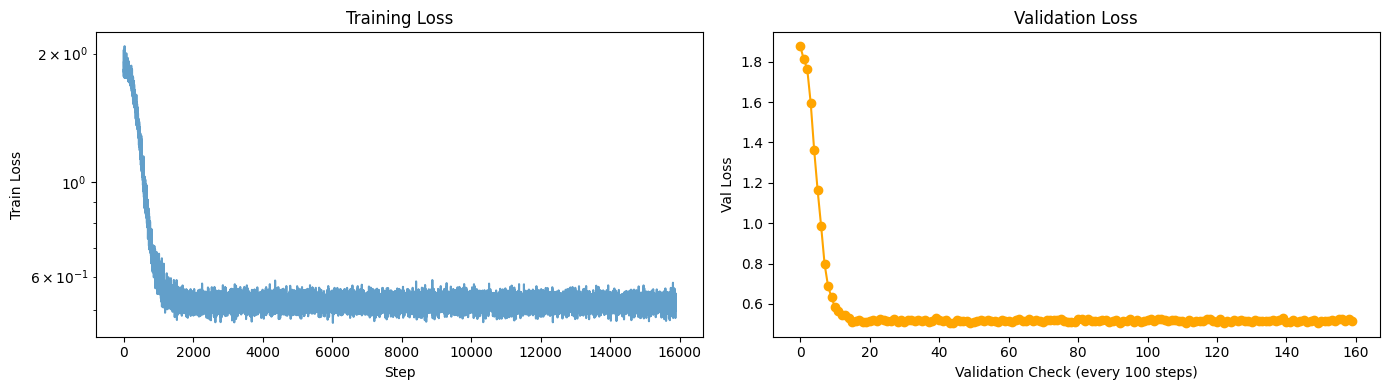

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(lossi, alpha=0.7)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Train Loss')
axes[0].set_title('Training Loss')
axes[0].set_yscale('log')

axes[1].plot(val_lossi, 'o-', color='orange')
axes[1].set_xlabel('Validation Check (every 100 steps)')
axes[1].set_ylabel('Val Loss')
axes[1].set_title('Validation Loss')

plt.tight_layout()
plt.show()

In [15]:
print('='*60)
print('TRAINING COMPLETE')
print('='*60)
print(f'Final train loss: {lossi[-1]:.4f}')
print(f'Final val loss: {val_lossi[-1]:.4f}')
print(f'Checkpoint saved: {checkpoint_dir / f"linear_decoder_ckpt_{max_steps-1}_final.pt"}')
print('='*60)

TRAINING COMPLETE
Final train loss: 0.5295
Final val loss: 0.5129
Checkpoint saved: /Users/djemec/data/jepa/v0_4/checkpoints/linear_decoder_ckpt_15884_final.pt
